# Use the pretrained ViTs and add two new tokens

`[CMD]` and `[SPD]` tokens will be concatenated at the end of the input sequence

In [1]:
import torch
import torchvision

model = torchvision.models.vit_b_32(pretrained=True)

In [2]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [26]:
from PIL import Image

image_size = model.image_size
patch_size = model.patch_size
hidden_dim = model.hidden_dim

source_img = Image.open('test_images/rgb_central002282.png')
source_img = source_img.resize((image_size, image_size))
source_img = torchvision.transforms.ToTensor()(source_img).unsqueeze(0)  # [1, 3, 224, 224]

In [22]:
torch.softmax(model(source_img), dim=1).max()

tensor(0.0350, grad_fn=<MaxBackward1>)

## Typical ViT pipeline

The following is basically the `forward` method of the `VisionTransformer` class in `torchvision.models`

In [27]:
model.conv_proj(torch.randn(3, 3, 224, 224)).shape

torch.Size([3, 768, 7, 7])

In [18]:
# Pass the image through the convolutional/patch embedding layer
# _process_input
img = model.conv_proj(source_img)  # [1, 3, 224, 224] => [1, 768, 7, 7]
img = img.reshape(1, hidden_dim, (image_size // patch_size) ** 2)  # [1, 768, 7, 7] => [1, 768, 49]
img = img.permute(0, 2, 1)  # [1, 768, 49] => [1, 49, 768]

# Now the rest of forward
# Add the class token
cls_token = model.class_token
n = img.shape[0]

# Expand class token to match batch size
cls_token = cls_token.expand(n, -1, -1)  # [1, 1, 768] => [1, 1, 768]
img = torch.cat([cls_token, img], dim=1)  # [1, 50, 768]])

# Pass the image through the encoder (we implicitly add the pos_embedding here)
# TODO: here, add the Command and Speed "tokens" (next for ablation study, for now just the mapping)
img = img + nn.Linear(1, hidden_dim)(torch.ones(1, requires_grad=True)).view(1, 1, hidden_dim)  # SPEED [1, 50, 768] => [1, 50, 768]
img = img + nn.Linear(4, hidden_dim)(torch.ones(4, requires_grad=True)).view(1, 1, hidden_dim)  # COMMAND [1, 50, 768] => [1, 50, 768]
img = model.encoder(img)  # [1, 50, 768] => [1, 50, 768]

# Pass the result to the head for classification (only the CLS token is used)
img = img[:, 0]  # [1, 50, 768] => [1, 768]
img = model.heads(img)  # [1, 768] => [1, 1000]

In [19]:
print(img.shape)

torch.Size([1, 1000])


In [11]:
model.class_token.shape

torch.Size([1, 1, 768])

In [15]:
type(model.encoder.pos_embedding)

torch.nn.parameter.Parameter

So, if we add `[CMD]` and `[SPD]` tokens to the input sequence, we must interpolate the positional embedding to be of size `[1, 52, 768]`, bascially. We can redefine the `interpolate_embeddings` function from `torchvision.models.vision_transformer` to do this:

In [14]:
help(torchvision.models.vision_transformer.interpolate_embeddings)

Help on function interpolate_embeddings in module torchvision.models.vision_transformer:

interpolate_embeddings(image_size: int, patch_size: int, model_state: 'OrderedDict[str, torch.Tensor]', interpolation_mode: str = 'bicubic', reset_heads: bool = False) -> 'OrderedDict[str, torch.Tensor]'
    This function helps interpolating positional embeddings during checkpoint loading,
    especially when you want to apply a pre-trained model on images with different resolution.
    
    Args:
        image_size (int): Image size of the new model.
        patch_size (int): Patch size of the new model.
        model_state (OrderedDict[str, torch.Tensor]): State dict of the pre-trained model.
        interpolation_mode (str): The algorithm used for upsampling. Default: bicubic.
        reset_heads (bool): If true, not copying the state of heads. Default: False.
    
    Returns:
        OrderedDict[str, torch.Tensor]: A state dict which can be loaded into the new model.



In [20]:
state = model.state_dict()

In [23]:
state['encoder.pos_embedding'].shape

torch.Size([1, 50, 768])

In [ ]:
import math
from collections import OrderedDict
import torch.nn as nn

def interpolate_embeddings(
    image_size: int,
    patch_size: int,
    model_state: "OrderedDict[str, torch.Tensor]",
    interpolation_mode: str = "bicubic",
    reset_heads: bool = False,
) -> "OrderedDict[str, torch.Tensor]":
    """This function helps interpolating positional embeddings during checkpoint loading,
    especially when you want to apply a pre-trained model on images with different resolution.

    Args:
        image_size (int): Image size of the new model.
        patch_size (int): Patch size of the new model.
        model_state (OrderedDict[str, torch.Tensor]): State dict of the pre-trained model.
        interpolation_mode (str): The algorithm used for upsampling. Default: bicubic.
        reset_heads (bool): If true, not copying the state of heads. Default: False.

    Returns:
        OrderedDict[str, torch.Tensor]: A state dict which can be loaded into the new model.
    """
    # Shape of pos_embedding is (1, seq_length, hidden_dim)
    pos_embedding = model_state["encoder.pos_embedding"]
    n, seq_length, hidden_dim = pos_embedding.shape
    if n != 1:
        raise ValueError(f"Unexpected position embedding shape: {pos_embedding.shape}")

    new_seq_length = (image_size // patch_size) ** 2 + 1

    # Need to interpolate the weights for the position embedding.
    # We do this by reshaping the positions embeddings to a 2d grid, performing
    # an interpolation in the (h, w) space and then reshaping back to a 1d grid.

    # The class token embedding shouldn't be interpolated so we split it up.
    seq_length -= 1
    new_seq_length -= 1
    pos_embedding_token = pos_embedding[:, :1, :]  # [1, 1, 768]
    pos_embedding_img = pos_embedding[:, 1:, :]  # [1, seq_length, 768]  ( we have already decreased seq_length by 1)

    # (1, seq_length, hidden_dim) -> (1, hidden_dim, seq_length)
    pos_embedding_img = pos_embedding_img.permute(0, 2, 1)
    seq_length_1d = int(math.sqrt(seq_length))
    torch._assert(seq_length_1d * seq_length_1d == seq_length, "seq_length is not a perfect square!")

    # (1, hidden_dim, seq_length) -> (1, hidden_dim, seq_l_1d, seq_l_1d)
    pos_embedding_img = pos_embedding_img.reshape(1, hidden_dim, seq_length_1d, seq_length_1d)
    new_seq_length_1d = image_size // patch_size

    # Perform interpolation.
    # (1, hidden_dim, seq_l_1d, seq_l_1d) -> (1, hidden_dim, new_seq_l_1d, new_seq_l_1d)
    new_pos_embedding_img = nn.functional.interpolate(
        pos_embedding_img,
        size=new_seq_length_1d,
        mode=interpolation_mode,
        align_corners=True,
    )

    # (1, hidden_dim, new_seq_l_1d, new_seq_l_1d) -> (1, hidden_dim, new_seq_length)
    new_pos_embedding_img = new_pos_embedding_img.reshape(1, hidden_dim, new_seq_length)

    # (1, hidden_dim, new_seq_length) -> (1, new_seq_length, hidden_dim)
    new_pos_embedding_img = new_pos_embedding_img.permute(0, 2, 1)
    new_pos_embedding = torch.cat([pos_embedding_token, new_pos_embedding_img], dim=1)

    model_state["encoder.pos_embedding"] = new_pos_embedding

    if reset_heads:
        model_state_copy: "OrderedDict[str, torch.Tensor]" = OrderedDict()
        for k, v in model_state.items():
            if not k.startswith("heads"):
                model_state_copy[k] = v
        model_state = model_state_copy

    return model_state

In [ ]:
def interpolate_pos_embedding(model: nn.Module, new_pos_embed_seq_len: int) -> 'OrderedDict[str, torch.Tensor]':
    """ Interpolate position encoding to the new sequence length. """
    old_state_dict = model.state_dict()

    # Get the position embedding from the old model
    pos_embed = old_state_dict["encoder.pos_embedding"]
    n, old_seq_len, d = pos_embed.shape
    pass
    
        

## Getting the attention maps

In [7]:
getattr(model.encoder.layers, f'encoder_layer_{0}')

EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (linear_1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU()
    (dropout_1): Dropout(p=0.0, inplace=False)
    (linear_2): Linear(in_features=3072, out_features=768, bias=True)
    (dropout_2): Dropout(p=0.0, inplace=False)
  )
)

In [35]:
# Just for the first layer
n, c, h, w = source_img.shape
patch_size = model.patch_size

n_h = h // patch_size
n_w = w // patch_size

pos_embed = model.encoder.pos_embedding  # [1, 50, 768]

x = model.conv_proj(source_img)  # [1, 768, 7, 7]
x = x.reshape(n, model.hidden_dim, n_h * n_w).permute(0, 2, 1)  # [1, 49, 768]

batch_class_token = model.class_token.expand(n, -1, -1)  # [1, 1, 768]
x = torch.cat((batch_class_token, x), dim=1)  # [1, 50, 768]
x = x + pos_embed  # [1, 50, 768]

x = model.encoder(x)  # [1, 50, 768]

x = x[:, 0]  # [1, 768]

x = model.heads(x)  # [1, 1000]

print(x.shape)

torch.Size([1, 1000])


In [66]:
# Just for the first layer
n, c, h, w = source_img.shape
patch_size = model.patch_size

n_h = h // patch_size
n_w = w // patch_size

x = model.conv_proj(source_img)  # [1, 768, 7, 7]
x = x.reshape(n, model.hidden_dim, n_h * n_w).permute(0, 2, 1)  # [1, 49, 768]

batch_class_token = model.class_token.expand(n, -1, -1)  # [1, 1, 768]
x = torch.cat((batch_class_token, x), dim=1)  # [1, 50, 768]
x = x + model.encoder.pos_embedding  # [1, 50, 768]

layer0 = getattr(model.encoder.layers, f'encoder_layer_{0}')

x0 = layer0.ln_1(x)
print(1, x0.shape)
x0, a = layer0.self_attention(x0, x0, x0, need_weights=True, average_attn_weights=True)  # THIS IS IT MOTHELDJFSFD
print(2, x0.shape, a.shape)
x0 = layer0.dropout(x0)
print(3, x0.shape)
x0 = x0 + x
print(4, x0.shape)
x1 = layer0.ln_2(x0)
print(5, x1.shape)
x1 = layer0.mlp(x1)
print(6, x1.shape)
x2 = x0 + x1
print(7, x2.shape)
# x = layer0(x)

1 torch.Size([1, 50, 768])
2 torch.Size([1, 50, 768]) torch.Size([1, 50, 50])
3 torch.Size([1, 50, 768])
4 torch.Size([1, 50, 768])
5 torch.Size([1, 50, 768])
6 torch.Size([1, 50, 768])
7 torch.Size([1, 50, 768])


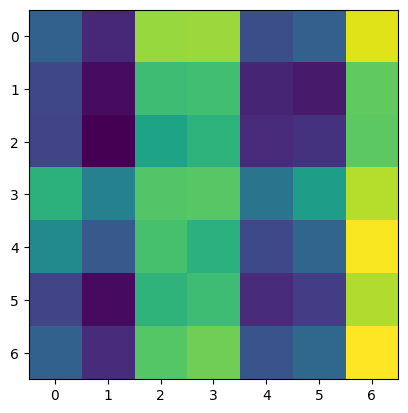

In [80]:
plt.imshow(a[0][0, 1:].view(7,7).cpu().detach().numpy())

In [71]:
att_layer0 = a[0, 0, 1:]
att_layer0 = att_layer0.view(1, n_h, n_w)
att_layer0 = att_layer0.permute(1, 2, 0)

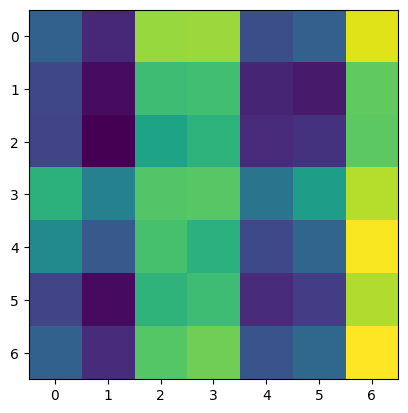

In [74]:
import matplotlib.pyplot as plt

plt.imshow(att_layer0[:, :, 0].cpu().detach().numpy())


In [82]:
att_layer0.max()

tensor(0.0181, grad_fn=<MaxBackward1>)

In [116]:
n, c, h, w = source_img.shape
patch_size = model.patch_size

n_h = h // patch_size
n_w = w // patch_size

x = model.conv_proj(source_img)  # [1, 768, 7, 7]
x = x.reshape(n, model.hidden_dim, n_h * n_w).permute(0, 2, 1)  # [1, 49, 768]

batch_class_token = model.class_token.expand(n, -1, -1)  # [1, 1, 768]
x = torch.cat((batch_class_token, x), dim=1)  # [1, 50, 768]
x = x + model.encoder.pos_embedding  # [1, 50, 768]

def preprocess_input_image(source_img: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    """ 
    Preprocess the input image (patchify and add positional embeddings)
        source_img: of shape [batch_size, channels, height, width]
        model: the ViT model from torchvision (i.e., torchvision.models.vit_b_32)
            Returns: a tensor of shape [batch_size, seq_length + 1, hidden_dim]
    """
    n, c, h, w = source_img.shape
    patch_size = model.patch_size

    n_h = h // patch_size
    n_w = w // patch_size

    x = model.conv_proj(source_img)  # [1, 768, 7, 7]
    x = x.reshape(n, model.hidden_dim, n_h * n_w).permute(0, 2, 1)  # [1, 49, 768]

    batch_class_token = model.class_token.expand(n, -1, -1)  # [1, 1, 768]
    x = torch.cat((batch_class_token, x), dim=1)  # [1, 50, 768]
    x = x + model.encoder.pos_embedding  # [1, 50, 768]

    return x

def get_attention_weights(model: torch.nn.Module, 
                          layer: int, 
                          input_tensor: torch.Tensor, 
                          need_weights: bool = True,
                          average_attn_weights: bool = True) -> torch.Tensor:
    """ 
    Extract the attention weights from a model at the specified layer
        layer: 0-11 or from 0 to the max number of layers in the model minus one
        input_tensor: the input tensor to the model; of shape [batch_size, seq_length+1, hidden_dim]
        Returns: a tensor of shape [batch_size, num_heads, seq_length+1, seq_length+1]
    """
    # Sanity check
    layer = max(0, min((layer, len(model.encoder.layers) - 1)))

    encoder_layer = getattr(model.encoder.layers, f'encoder_layer_{layer}')
    
    x0 = encoder_layer.ln_1(input_tensor)
    x0, a = encoder_layer.self_attention(x0, x0, x0, need_weights=need_weights, average_attn_weights=average_attn_weights)
    x0 = encoder_layer.dropout(x0)
    x0 = x0 + input_tensor
    x1 = encoder_layer.ln_2(x0)
    x1 = encoder_layer.mlp(x1)
    x2 = x0 + x1  # [batch_size, seq_length+1, hidden_dim]

    return x2, a  # [batch_size, seq_length+1, hidden_dim], [batch_size, num_heads, seq_length+1, seq_length+1]

In [130]:
model = torchvision.models.vit_b_32(pretrained=True)

x = preprocess_input_image(source_img, model)

specific_layer = 11

for layer in range(len(model.encoder.layers)):
    if layer == specific_layer:
        x, a = get_attention_weights(model, layer, x, average_attn_weights=True)
    else:
        x, _ = get_attention_weights(model, layer, x, need_weights=False)

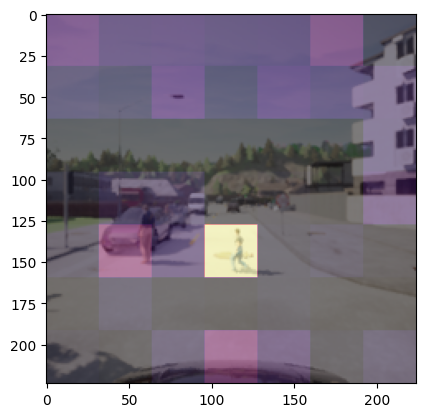

In [131]:
import cv2

# Plot the original image
plt.imshow(source_img[0].permute(1, 2, 0).cpu().detach().numpy())
# Plot the attention weights (resized to the original image size)
z = cv2.resize(a[0, 0, 1:].view(n_h, n_w).cpu().detach().numpy(), (source_img.shape[2], source_img.shape[3]), interpolation=cv2.INTER_AREA)
plt.imshow(z, alpha=0.5, cmap='inferno')

### Plot all the attention maps per layer

In [165]:
model = torchvision.models.vit_b_32(pretrained=True)

x = preprocess_input_image(source_img, model)

att_map_dict = {}

for i in range(len(model.encoder.layers)):

    x, a = get_attention_weights(model, i, x, average_attn_weights=True)
    att_map_dict[i] = a

In [181]:
import numpy as np
from typing import Dict

def plot_attention_maps(source_img: torch.Tensor, 
                        model: torch.nn.Module, 
                        att_map_dict: Dict[int, torch.Tensor] = None,
                        figsize: tuple = (12, 8)) -> None:
    """ 
    Plot the attention maps for each layer in att_map_dict
        source_img: of shape [batch_size, channels, height, width]
        model: the ViT model from torchvision (i.e., torchvision.models.vit_b_32)
        att_map_dict: a dictionary of attention maps for each layer
    """
    n, c, h, w = source_img.shape
    patch_size = model.patch_size

    n_h = h // patch_size
    n_w = w // patch_size

    if att_map_dict is None:
        att_map_dict = {}

        x = preprocess_input_image(source_img, model)

        for i in range(len(model.encoder.layers)):
            x, a = get_attention_weights(model, i, x, average_attn_weights=True)
            att_map_dict[i] = a

    # Plot the attention map for each layer in att_map_dict (resized to the original image size)
    nr = int(np.rint(np.sqrt(len(att_map_dict))))
    nc = int(np.ceil(len(att_map_dict) / nr))

    plt.figure(figsize=figsize)
    for layer, att_map in att_map_dict.items():
        plt.subplot(nr, nc, layer + 1)
        plt.imshow(source_img[0].permute(1, 2, 0).cpu().detach().numpy())

        z = cv2.resize(att_map[0, 0, 1:].view(n_h, n_w).cpu().detach().numpy(), (h, w), interpolation=cv2.INTER_AREA)
        plt.imshow(z, alpha=0.5, cmap='inferno', interpolation='none')
        plt.axis('off')
        plt.title(f'Layer {layer}')
    plt.show()

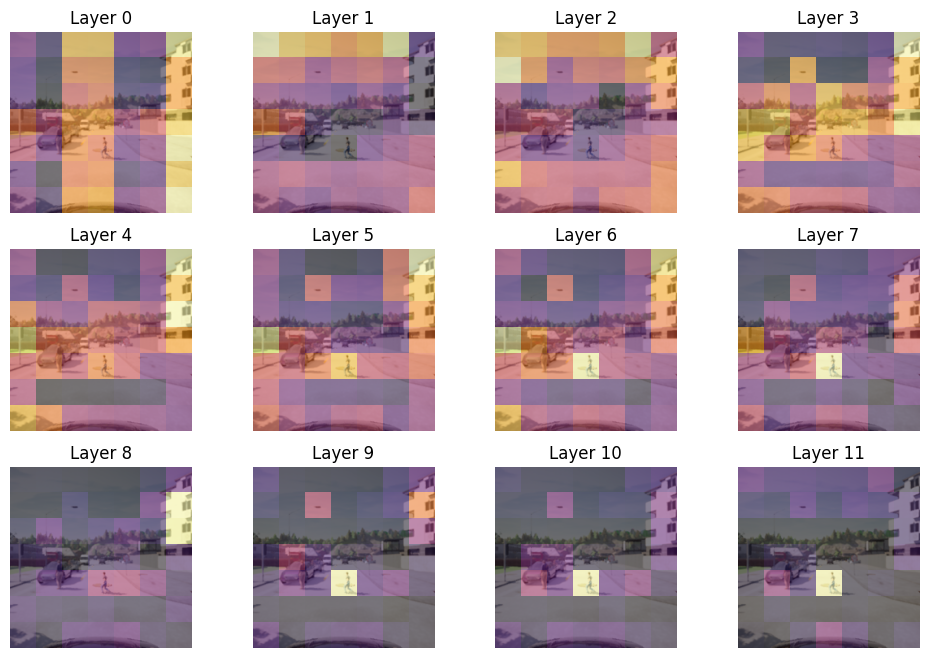

In [182]:
src_img = Image.open('test_images/rgb_central002282.png').convert('RGB')
src_img = src_img.resize((image_size, image_size))
src_img = torchvision.transforms.ToTensor()(src_img).unsqueeze(0)  # [1, 3, 224, 224]

plot_attention_maps(src_img, model)

In [183]:
def load_image(image_path: str, image_size: int = 224)-> torch.Tensor:
    img = Image.open(image_path).convert('RGB')
    img = img.resize((image_size, image_size))
    img = torchvision.transforms.ToTensor()(img).unsqueeze(0)  # [1, 3, 224, 224]

    return img

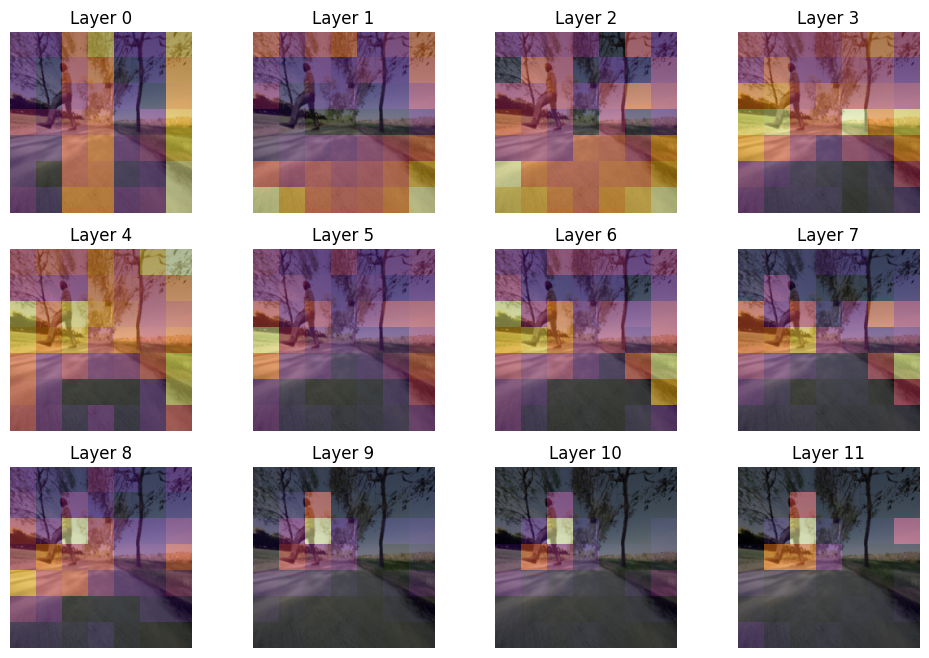

In [185]:
model = torchvision.models.vit_b_32(pretrained=True)

image_size = model.image_size
patch_size = model.patch_size
hidden_dim = model.hidden_dim
num_layers = len(model.encoder.layers)

src_img = load_image('test_images/audirc_rgb_central003595.png')

x = preprocess_input_image(src_img, model)

att_map_dict3 = {}

for i in range(num_layers):

    x, a = get_attention_weights(model, i, x, average_attn_weights=True)
    att_map_dict3[i] = a

plot_attention_maps(src_img, model, att_map_dict3)

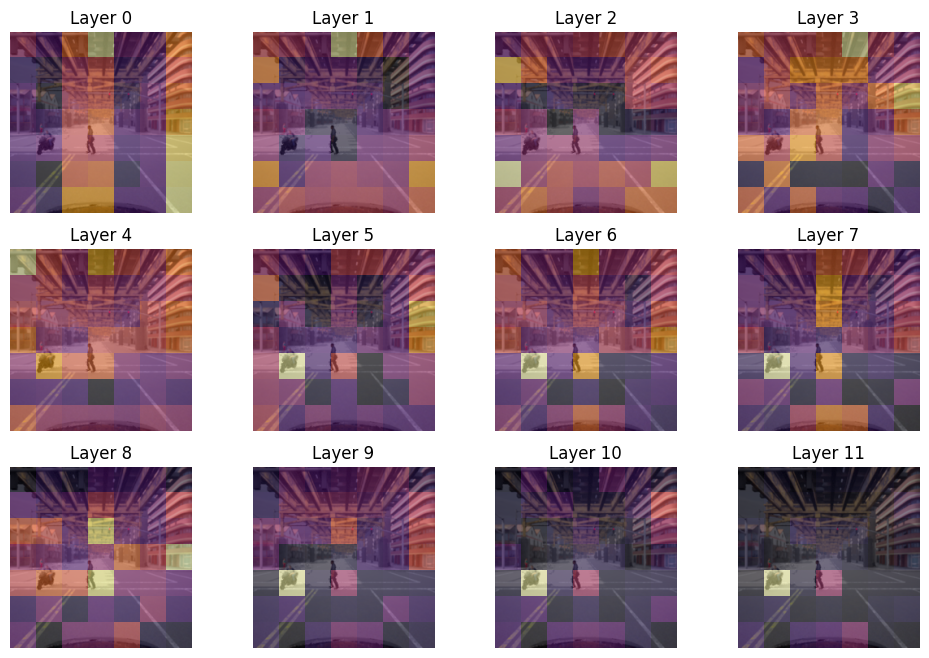

In [186]:
model = torchvision.models.vit_b_32(pretrained=True)

image_size = model.image_size
patch_size = model.patch_size
hidden_dim = model.hidden_dim
num_layers = len(model.encoder.layers)

src_img = load_image('test_images/t03_rs01_rgb_central000174.png')

x = preprocess_input_image(src_img, model)

att_map_dict3 = {}

for i in range(num_layers):

    x, a = get_attention_weights(model, i, x, average_attn_weights=True)
    att_map_dict3[i] = a

plot_attention_maps(src_img, model, att_map_dict3)

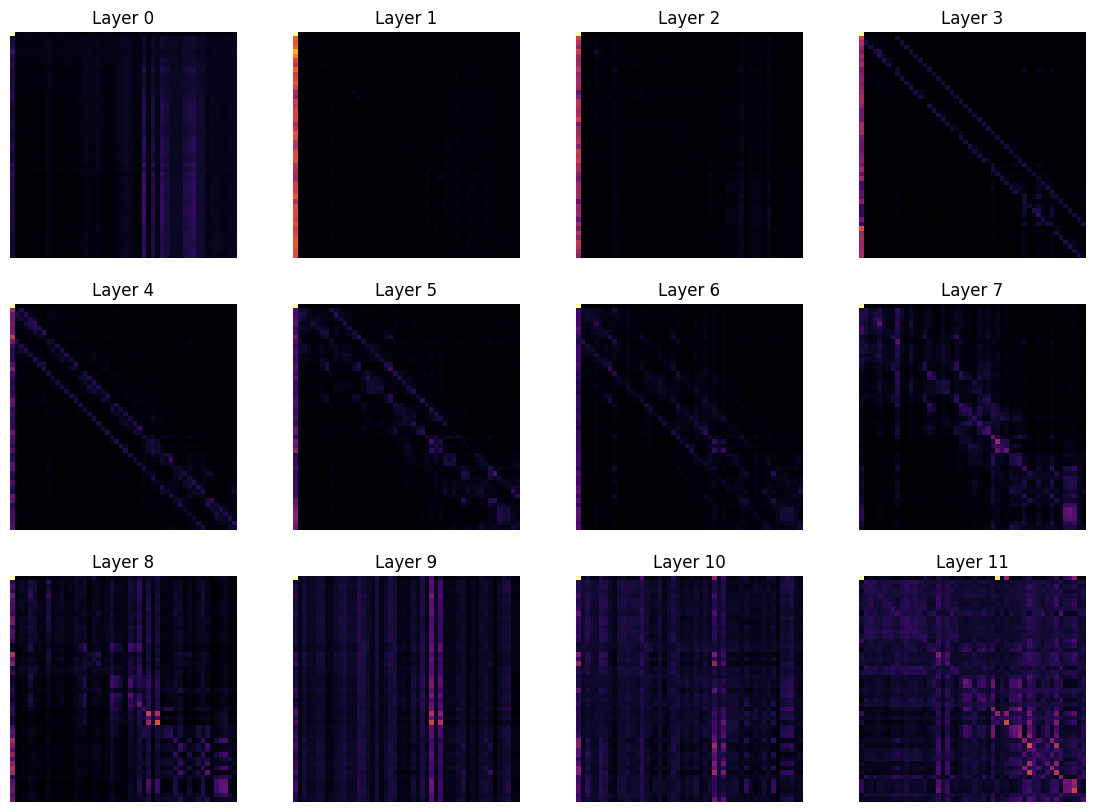

In [176]:
# Plot the attention map for each layer in att_map_dict (resized to the original image size)
nr = int(np.rint(np.sqrt(num_layers)))
nc = int(np.ceil(num_layers / nr))

plt.figure(figsize=(14, 10))
for layer, att_map in att_map_dict3.items():
    plt.subplot(nr, nc, layer + 1)
    plt.imshow(att_map[0].cpu().detach().numpy(), cmap='inferno', interpolation='none')
    plt.axis('off')
    plt.title(f'Layer {layer}')
plt.show()

In [ ]:
# Extract the attention map of a specific layer of a Vision Transformer
# Define a forward wrapper to extract the attention map

class AttentionMapExtractor(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        if self.model._get_name() == 'VisionTransformer':
            self.encoder = model.encoder
        else:
            # It's the CILv2 model
            try:
                self.encoder = model._model.encoder_embedding_perception.encoder
            except AttributeError:
                self.encoder = model.encoder_embedding_perception.encoder
        # Model characteristics
        self.image_size = model.image_size
        self.patch_size = model.patch_size
        self.hidden_dim = model.hidden_dim
        self.num_layers = len(self.encoder.layers)

    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def get_attention_map_layer(self, layer: int):
        x = preprocess_input_image(src_img, model)

        att_map_dict3 = {}

        for i in range(num_layers):

            x, a = get_attention_weights(model, i, x, average_attn_weights=True)
            att_map_dict3[i] = a
        
        return self.model.encoder.layers[layer].attn.attn[0].cpu().detach().numpy()


# Usage
model = AttentionMapExtractor(model)
model.eval()

# Extract the attention map of a specific layer of a Vision Transformer

def extract_attention_map(model: nn.Module, 
                          layer: int):
    """ Extract the attention map of a specific layer of a Vision Transformer """
    encoder = model.encoder
    num_layers = len(encoder.layers)
    layer = max(0, min(layer, num_layers - 1))  # Sanity check
    # Get the specific layer
    layer = getattr(model.encoder.layers, f'encoder_layer_{layer}')
    # Get the attention map of a specific layer
    attn_map = model.encoder.layers[layer].attn.attn[0].cpu().detach().numpy()  # [1, 12, 50, 50]

    # Get the attention map of the first head
    attn_map = attn_map[0]  # [50, 50]

    # Plot the attention map
    plt.imshow(attn_map)
    plt.show()